In [2]:
!pip install realesrgan gfpgan

In [3]:
!pip install transformers accelerate safetensors diffusers

  Obtaining dependency information for diffusers from https://files.pythonhosted.org/packages/7c/0b/cc9ba8f09910678e5ce3374476269b7b2a5b9a67c06ff68bf0a20206e7bb/diffusers-0.26.3-py3-none-any.whl.metadata
  Obtaining dependency information for huggingface-hub<1.0,>=0.16.4 from https://files.pythonhosted.org/packages/ab/28/d4b691840d73126d4c9845f8a22dad033ac872509b6d3a0d93b456eef424/huggingface_hub-0.21.4-py3-none-any.whl.metadata
INFO: pip is looking at multiple versions of tokenizers to determine which version is compatible with other requirements. This could take a while.
  Obtaining dependency information for tokenizers<0.15,>=0.14 from https://files.pythonhosted.org/packages/57/bd/45b5ef6b088880779f70acf60027f7043ca5fa1b98f4a4345cf3aea09044/tokenizers-0.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for diffusers from https://files.pythonhosted.org/packages/a9/17/be135f486da06dbc5d68897e528486b59cef3af1463563ab1496a09cf52b

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [5]:
import os
import requests
import base64
import cv2
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
from PIL import Image
from gfpgan.utils import GFPGANer
from realesrgan.utils import RealESRGANer
from basicsr.archs.srvgg_arch import SRVGGNetCompact
from IPython.display import display
import os
import requests
from diffusers import DiffusionPipeline, StableDiffusionXLImg2ImgPipeline 
from torchvision.transforms import ToTensor, Normalize, ConvertImageDtype



The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [6]:

model_urls = {
    'realesr-general-x4v3.pth': "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.5.0/realesr-general-x4v3.pth",
    'GFPGANv1.4.pth': "https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.4.pth",
}

# Create a directory for the weights if it doesn't exist
os.makedirs('weight', exist_ok=True)

def download_file(url, filename):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)
        print(f"Downloaded {filename}")
    else:
        print(f"Failed to download {filename}. Status code: {response.status_code}")

for filename, url in model_urls.items():
    file_path = os.path.join('weight', filename)
    if not os.path.exists(file_path):
        print(f"Downloading {filename}...")
        download_file(url, file_path)
    else:
        print(f"{filename} already exists. Skipping download.")

Downloaded weight/realesr-general-x4v3.pth
Downloaded weight/GFPGANv1.4.pth


In [7]:
import torch  
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [8]:
device

device(type='cuda')

In [9]:
print(os.listdir('weight'))

['realesr-general-x4v3.pth', 'GFPGANv1.4.pth']


In [10]:
# Load RealESRGAN model
realesrgan_model_path = 'weight/realesr-general-x4v3.pth'

# Initialize RealESRGAN
sr_model = SRVGGNetCompact(num_in_ch=3, num_out_ch=3, num_feat=64, num_conv=32, upscale=4, act_type='prelu')
half = True if torch.cuda.is_available() else False
realesrganer = RealESRGANer(scale=4, model_path=realesrgan_model_path, model=sr_model, tile=0, tile_pad=10, pre_pad=0, half=half)

# Function to upscale image with RealESRGAN
def upscale_image(image_path, output_path):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    # Upscale the image with RealESRGAN
    output, _ = realesrganer.enhance(img, outscale=4)
    cv2.imwrite(output_path, output)
    return output

In [11]:

gfpgan_model_path = '/kaggle/working/weight/GFPGANv1.4.pth'


face_enhancer = GFPGANer(model_path=gfpgan_model_path, upscale=10, arch='clean', 
                         channel_multiplier=2, bg_upsampler=realesrganer)
def enhance_faces(image_path, output_path):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    # Enhance faces with GFPGAN
    _, _, img_enhanced = face_enhancer.enhance(img, has_aligned=False, 
                                               only_center_face=False, 
                                               paste_back=True)
    cv2.imwrite(output_path, img_enhanced)
    return img_enhanced

Downloading: "https://github.com/xinntao/facexlib/releases/download/v0.1.0/detection_Resnet50_Final.pth" to /kaggle/working/gfpgan/weights/detection_Resnet50_Final.pth



100%|██████████| 104M/104M [00:00<00:00, 322MB/s] 


Downloading: "https://github.com/xinntao/facexlib/releases/download/v0.2.2/parsing_parsenet.pth" to /kaggle/working/gfpgan/weights/parsing_parsenet.pth



100%|██████████| 81.4M/81.4M [00:00<00:00, 311MB/s]


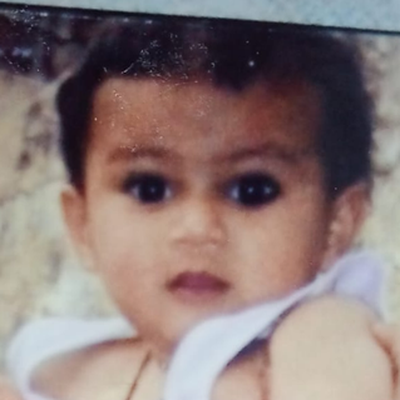

In [12]:
initial_image_path = r'/kaggle/input/gfpgan-inputs/Whats.png'
# Load the image with PIL
photo = Image.open(initial_image_path)
# Display the image with a specific max width and height
display(photo.resize((400, 400), Image.LANCZOS))

In [13]:
def compare_image_enhancement(initial_image_path, enhanced_faces_path):

    try:
        initial_image = Image.open(initial_image_path)
        enhanced_image = Image.open(enhanced_faces_path)
    except FileNotFoundError as err:
        print(f"Error loading images: {err}")
        return

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    ax1.imshow(initial_image)
    ax1.set_title("Original Image")
    ax1.axis("off")  

    ax2.imshow(enhanced_image)
    ax2.set_title("Enhanced Image")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

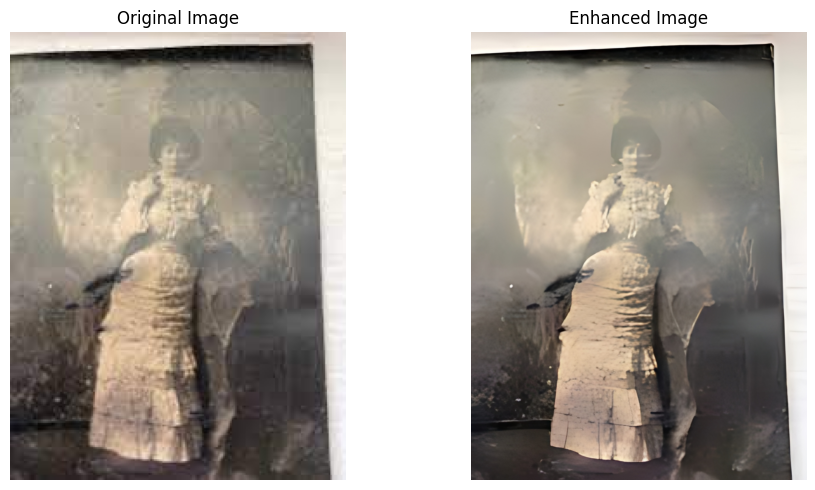

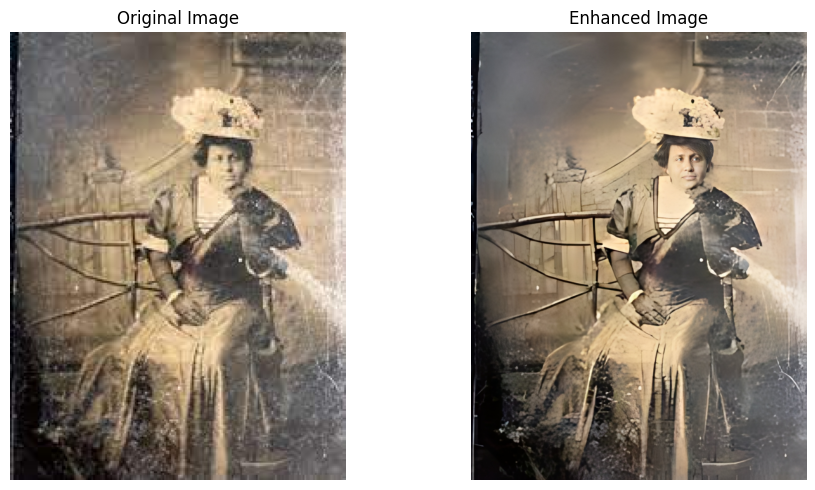

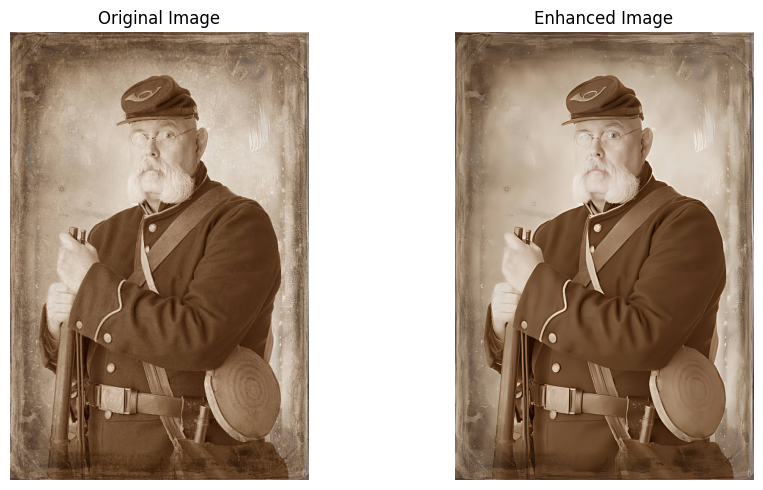

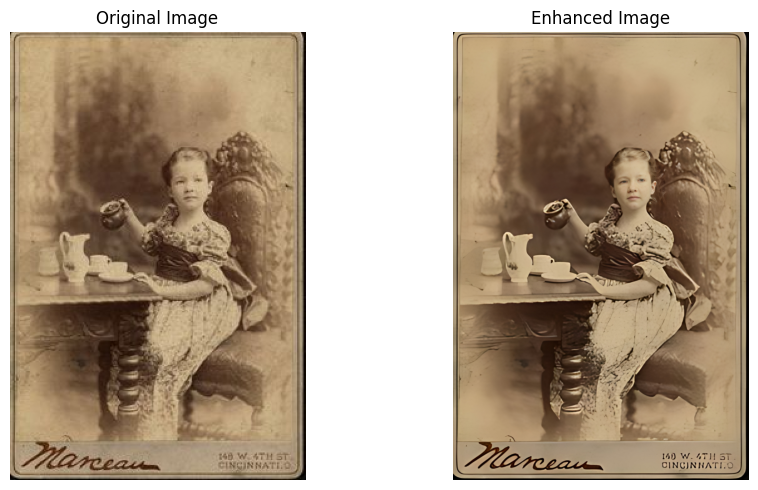

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (94960000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
enhanced_faces_path = "/kaggle/working/"
input_folder = '/kaggle/input/old-photos'
output_folder = '/kaggle/working/enhanced/'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for filename in os.listdir(input_folder):
    if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):  # Check for image files
        initial_image_path = os.path.join(input_folder, filename)
        output_filename = os.path.splitext(filename)[0] + '_enhanced.jpg'  # Modified naming
        enhanced_faces_path = os.path.join(output_folder, output_filename)

        try:
            enhance_faces(initial_image_path, enhanced_faces_path)
            compare_image_enhancement(initial_image_path, enhanced_faces_path)
        except Exception as err:
            print(f"Error processing {filename}: {err}")